In [27]:
import pandas as pd
timetable = pd.read_excel('Connexxion data - 2024-2025.xlsx', sheet_name='Dienstregeling')
afstandsmatrix = pd.read_excel('Connexxion data - 2024-2025.xlsx', sheet_name='Afstandsmatrix')

# Bekijk het resultaat
df = pd.merge(
    timetable,
    afstandsmatrix,
    how='right',  # Kies 'left' als je alle rijen uit timetable wilt behouden
    left_on=['startlocatie', 'eindlocatie', 'buslijn'],
    right_on=['startlocatie', 'eindlocatie', 'buslijn']
)

df['vertrektijd'] = pd.to_datetime(df['vertrektijd'], format='%H:%M')
df['eindtijd'] = df['vertrektijd'] + pd.to_timedelta(df['max reistijd in min'], unit='minutes')
df['eindtijd'] = pd.to_datetime(df['eindtijd'], format='%H:%M')

df.head(20)

,startlocatie,vertrektijd,eindlocatie,buslijn,min reistijd in min,max reistijd in min,afstand in meters,eindtijd
0,ehvapt,1900-01-01 07:19:00,ehvbst,400.0,21,23,10250,1900-01-01 07:42:00
1,ehvapt,1900-01-01 07:34:00,ehvbst,400.0,21,23,10250,1900-01-01 07:57:00
2,ehvapt,1900-01-01 07:49:00,ehvbst,400.0,21,23,10250,1900-01-01 08:12:00
3,ehvapt,1900-01-01 08:04:00,ehvbst,400.0,21,23,10250,1900-01-01 08:27:00
4,ehvapt,1900-01-01 08:19:00,ehvbst,400.0,21,23,10250,1900-01-01 08:42:00
5,ehvapt,1900-01-01 08:27:00,ehvbst,400.0,21,23,10250,1900-01-01 08:50:00
6,ehvapt,1900-01-01 08:34:00,ehvbst,400.0,21,23,10250,1900-01-01 08:57:00
7,ehvapt,1900-01-01 08:49:00,ehvbst,400.0,21,23,10250,1900-01-01 09:12:00
8,ehvapt,1900-01-01 08:57:00,ehvbst,400.0,21,23,10250,1900-01-01 09:20:00
9,ehvapt,1900-01-01 09:04:00,ehvbst,400.0,21,23,10250,1900-01-01 09:27:00


In [79]:
import pandas as pd

def verdeel_ritten_met_vast_patroon(df, max_ritten_per_cyclus=10):
    """
    Verdeel ritten over omlopen met een vast patroon:
    - Na elke `max_ritten_per_cyclus` ritten: opladen en materiaalritten
    - Als de eindlocatie niet 'ehvbst' is, eerst rit van 'ehvapt' naar 'ehvbst' toevoegen.
    - Blijf in dezelfde omloop tot alle ritten zijn verwerkt.
    """
    new_rows = []  # Voor extra rijen (materiaalrit en opladen)
    omloop_nummer = 1  # Omloopnummer begint bij 1
    df = df.sort_values(by='vertrektijd').reset_index(drop=True)  # Sorteer ritten op tijd
    df['omloopnummer'] = None  # Kolom voor omloopnummer
    df['activiteit'] = None  # Kolom voor activiteit

    while not df[df['omloopnummer'].isna()].empty:  # Zolang er ongeplande ritten zijn
        # Start een nieuwe omloop
        ritten_in_omloop = 0
        laatst_eindlocatie = None
        laatst_eindtijd = None

        # Zoek de eerste ongeplande rit
        volgende_rit_index = df[df['omloopnummer'].isna()].index[0]
        df.at[volgende_rit_index, 'omloopnummer'] = omloop_nummer
        df.at[volgende_rit_index, 'activiteit'] = 'dienst rit'
        huidige_rit = df.loc[volgende_rit_index]
        laatst_eindlocatie = huidige_rit['eindlocatie']
        laatst_eindtijd = huidige_rit['eindtijd']
        ritten_in_omloop += 1

        while True:
            if ritten_in_omloop % max_ritten_per_cyclus == 0:
                # Check of de eindlocatie 'ehvbst' is na `max_ritten_per_cyclus` ritten
                if laatst_eindlocatie != 'ehvbst':
                    # Voeg rit van 'ehvapt' naar 'ehvbst' toe
                    new_rows.append({
                        'startlocatie': 'ehvapt',
                        'eindlocatie': 'ehvbst',
                        'vertrektijd': laatst_eindtijd,
                        'eindtijd': laatst_eindtijd + pd.Timedelta(minutes=20),
                        'activiteit': 'materiaalrit',
                        'buslijn': None,
                        'energieverbruik': 0.1,
                        'omloopnummer': omloop_nummer
                    })
                    laatst_eindlocatie = 'ehvbst'
                    laatst_eindtijd += pd.Timedelta(minutes=20)

                # Voeg materiaalrit en opladen toe na elke `max_ritten_per_cyclus` ritten
                new_rows.append({
                    'startlocatie': laatst_eindlocatie,
                    'eindlocatie': 'ehvgar',
                    'vertrektijd': laatst_eindtijd,
                    'eindtijd': laatst_eindtijd + pd.Timedelta(minutes=4),
                    'activiteit': 'materiaal rit',
                    'buslijn': None,
                    'energieverbruik': 0.1,
                    'omloopnummer': omloop_nummer
                })
                new_rows.append({
                    'startlocatie': 'ehvgar',
                    'eindlocatie': 'ehvgar',
                    'vertrektijd': laatst_eindtijd + pd.Timedelta(minutes=4),
                    'eindtijd': laatst_eindtijd + pd.Timedelta(minutes=19),
                    'activiteit': 'opladen',
                    'buslijn': None,
                    'energieverbruik': 0,
                    'omloopnummer': omloop_nummer
                })
                new_rows.append({
                    'startlocatie': 'ehvgar',
                    'eindlocatie': 'ehvbst',
                    'vertrektijd': laatst_eindtijd + pd.Timedelta(minutes=19),
                    'eindtijd': laatst_eindtijd + pd.Timedelta(minutes=23),
                    'activiteit': 'materiaalrit',
                    'buslijn': None,
                    'energieverbruik': 0.1,
                    'omloopnummer': omloop_nummer
                })

                laatst_eindtijd += pd.Timedelta(minutes=23)
                laatst_eindlocatie = 'ehvbst'

            # Zoek een aansluitende rit
            aansluitende_ritten = df[(
                df['omloopnummer'].isna()) & 
                (df['startlocatie'] == laatst_eindlocatie) &
                (df['vertrektijd'] >= laatst_eindtijd)
            ]

            if aansluitende_ritten.empty:
                # Geen aansluitende ritten meer, omloop klaar
                break
            else:
                # Pak de eerstvolgende rit
                volgende_rit_index = aansluitende_ritten.index[0]
                df.at[volgende_rit_index, 'omloopnummer'] = omloop_nummer
                df.at[volgende_rit_index, 'activiteit'] = 'dienst rit'
                volgende_rit = df.loc[volgende_rit_index]
                laatst_eindlocatie = volgende_rit['eindlocatie']
                laatst_eindtijd = volgende_rit['eindtijd']
                ritten_in_omloop += 1

        # Ga naar de volgende omloop
        omloop_nummer += 1

    # Voeg de nieuwe rijen toe aan het originele DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_rows_df], ignore_index=True).sort_values(by=['omloopnummer', 'vertrektijd'])
    
    return df

# Aanroepen van de functie
result = verdeel_ritten_met_vast_patroon(df, max_ritten_per_cyclus=10)

result.head(1)

KeyError: 'vertrektijd'

In [53]:
timetable = pd.read_excel('Connexxion data - 2024-2025.xlsx', sheet_name='Dienstregeling')
afstandsmatrix = pd.read_excel('Connexxion data - 2024-2025.xlsx', sheet_name='Afstandsmatrix')


In [47]:
timetable.head(1)

,startlocatie,vertrektijd,eindlocatie,buslijn
0,ehvapt,06:04,ehvbst,401


In [59]:
nieuwe_data = pd.read_excel('busplanning_10_ritten.xlsx')

nieuwe_data['starttijd'] = pd.to_datetime(nieuwe_data['starttijd'], format='%H:%M')
timetable['vertrektijd'] = pd.to_datetime(timetable['vertrektijd'], format='%H:%M')

result = pd.merge(
    nieuwe_data,
    timetable,
    how='left',  # Kies 'left' om alleen de rijen in df1 te behouden
    left_on=['startlocatie', 'eindlocatie', 'starttijd'],
    right_on=['startlocatie', 'eindlocatie', 'vertrektijd']
)
result

,Unnamed: 0,startlocatie,eindlocatie,starttijd,eindtijd,omloop nummer,activiteit,energieverbruik,vertrektijd,buslijn
0,0.0,ehvapt,ehvbst,1900-01-01 00:01:00,1900-01-01 00:26:00,1,dienst rit,NaN,1900-01-01 00:01:00,401.0
1,NaN,ehvbst,ehvgar,1900-01-01 00:26:00,1900-01-01 00:30:00,1,materiaal rit,NaN,NaT,NaN
2,NaN,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,1,materiaal rit,NaN,NaT,NaN
3,2.0,ehvbst,ehvapt,1900-01-01 05:07:00,1900-01-01 05:31:00,1,dienst rit,NaN,1900-01-01 05:07:00,401.0
4,3.0,ehvapt,ehvapt,1900-01-01 05:31:00,1900-01-01 06:04:00,1,idle,0.1,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
709,702.0,ehvbst,ehvbst,1900-01-01 12:50:00,1900-01-01 13:39:00,14,idle,0.1,NaT,NaN
710,703.0,ehvbst,ehvapt,1900-01-01 13:39:00,1900-01-01 14:03:00,14,dienst rit,NaN,1900-01-01 13:39:00,401.0
711,704.0,ehvapt,ehvapt,1900-01-01 14:03:00,1900-01-01 14:06:00,14,idle,0.1,NaT,NaN
712,705.0,ehvapt,ehvbst,1900-01-01 14:06:00,1900-01-01 14:31:00,14,dienst rit,NaN,1900-01-01 14:06:00,401.0


In [41]:
def vul_loze_tijd_op(df):
    """
    Vul loze tijd op tussen ritten met een 'idle' activiteit.
    """
    new_idle_rows = []
    df = df.sort_values(by=['omloopnummer', 'vertrektijd']).reset_index(drop=True)  # Sorteer op omloopnummer en tijd
    
    for i in range(len(df) - 1):
        huidige_rit = df.iloc[i]
        volgende_rit = df.iloc[i + 1]
        
        # Controleer of de ritten bij dezelfde omloop horen en een gat hebben
        if (
            huidige_rit['omloopnummer'] == volgende_rit['omloopnummer'] and
            huidige_rit['eindtijd'] < volgende_rit['vertrektijd']
        ):
            new_idle_rows.append({
                'startlocatie': huidige_rit['eindlocatie'],
                'eindlocatie': volgende_rit['startlocatie'],
                'vertrektijd': huidige_rit['eindtijd'],
                'eindtijd': volgende_rit['vertrektijd'],
                'activiteit': 'idle',
                'buslijn': None,
                'energieverbruik': 0.1,
                'omloopnummer': huidige_rit['omloopnummer']
            })
    
    # Voeg de nieuwe 'idle' rijen toe aan het DataFrame
    idle_df = pd.DataFrame(new_idle_rows)
    df = pd.concat([df, idle_df], ignore_index=True).sort_values(by=['omloopnummer', 'vertrektijd']).reset_index(drop=True)
    
    return df

# Pas de functie toe
result_with_idle = vul_loze_tijd_op(result)
result_with_idle.head(5)


C:\Users\ynieu\AppData\Local\Temp\ipykernel_1844\3098504277.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, idle_df], ignore_index=True).sort_values(by=['omloopnummer', 'vertrektijd']).reset_index(drop=True)


,startlocatie,vertrektijd,eindlocatie,buslijn,min reistijd in min,max reistijd in min,afstand in meters,eindtijd,omloopnummer,activiteit,energieverbruik
0,ehvapt,1900-01-01 00:01:00,ehvbst,401.0,22.0,25.0,9050.0,1900-01-01 00:26:00,1,dienst rit,NaN
1,ehvbst,1900-01-01 00:26:00,ehvbst,NaN,NaN,NaN,NaN,1900-01-01 05:07:00,1,idle,0.1
2,ehvbst,1900-01-01 05:07:00,ehvapt,401.0,22.0,24.0,9003.0,1900-01-01 05:31:00,1,dienst rit,NaN
3,ehvapt,1900-01-01 05:31:00,ehvapt,NaN,NaN,NaN,NaN,1900-01-01 06:04:00,1,idle,0.1
4,ehvapt,1900-01-01 06:04:00,ehvbst,401.0,22.0,25.0,9050.0,1900-01-01 06:29:00,1,dienst rit,NaN


C:\Users\ynieu\AppData\Local\Temp\ipykernel_1844\2757424051.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_planning['duration'] = (bus_planning['eindtijd'] - bus_planning['vertrektijd']).dt.total_seconds() / 3600
C:\Users\ynieu\AppData\Local\Temp\ipykernel_1844\2757424051.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_planning['duration'] = bus_planning['duration'].apply(lambda x: max(x, min_duration))
C:\Users\ynieu\AppData\Local\Temp\ipykernel_1844\2757424051.py:28: SettingWithCopyWarn

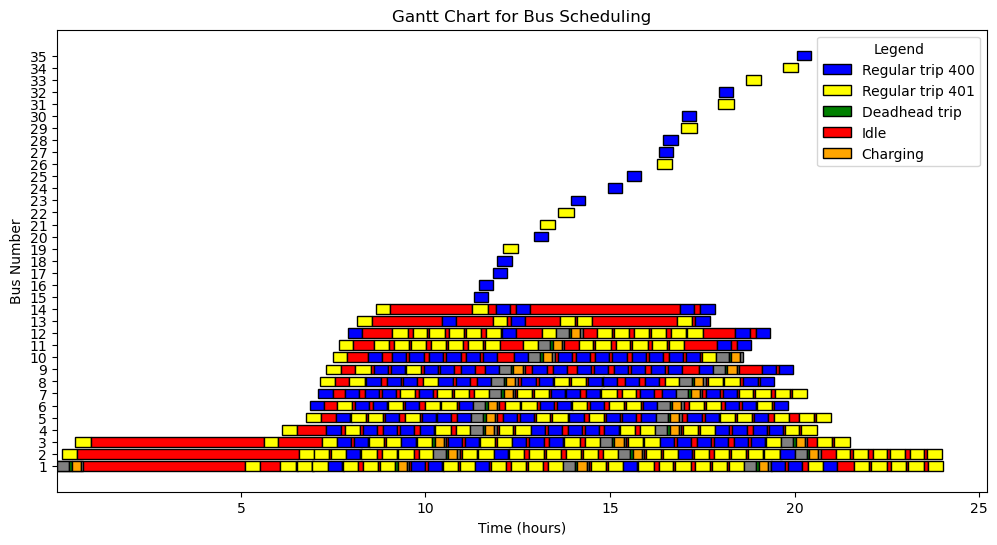

In [42]:
import matplotlib.pyplot as plt
def plot_schedule_from_excel(bus_planning):
    """Plot een Gantt-grafiek voor busplanning op basis van een DataFrame."""

    # Controleer of de vereiste kolommen aanwezig zijn
    required_columns = ['vertrektijd', 'eindtijd', 'buslijn', 'omloop nummer', 'activiteit']

    bus_planning['vertrektijd'] = pd.to_datetime(bus_planning['vertrektijd'], errors='coerce')
    bus_planning['eindtijd'] = pd.to_datetime(bus_planning['eindtijd'], errors='coerce')

    # Verwijder rijen met NaT in starttijd of eindtijd
    bus_planning = bus_planning.dropna(subset=['vertrektijd', 'eindtijd'])

    bus_planning['duration'] = (bus_planning['eindtijd'] - bus_planning['vertrektijd']).dt.total_seconds() / 3600

    min_duration = 0.05  
    bus_planning['duration'] = bus_planning['duration'].apply(lambda x: max(x, min_duration))

    color_map = {
        '400.0': 'blue',
        '401.0': 'yellow',
        'materiaal rit': 'green',
        'idle': 'red',
        'opladen': 'orange',
        'pauze': 'orange'
    }

    bus_planning['buslijn'] = bus_planning['buslijn'].astype(str)

    def determine_color(row):
        if pd.notna(row['buslijn']) and row['buslijn'] in color_map:
            return color_map[row['buslijn']]  
        elif row['activiteit'] in color_map:
            return color_map[row['activiteit']]  
        else:
            return 'gray' 

    bus_planning['color'] = bus_planning.apply(determine_color, axis=1)

    fig, ax = plt.subplots(figsize=(12, 6))
    omloopnummers = bus_planning['omloopnummer'].unique()
    omloop_indices = {omloop: i for i, omloop in enumerate(omloopnummers)}

    for omloop in omloopnummers:
        trips = bus_planning[bus_planning['omloopnummer'] == omloop]

        if trips.empty:
            ax.barh(omloop_indices[omloop], 1, left=0, color='black', edgecolor='black')
            continue

        for _, trip in trips.iterrows():
            starttime = trip['vertrektijd']
            duration = trip['duration']
            color = trip['color'] 

            ax.barh(omloop_indices[omloop], duration, left=starttime.hour + starttime.minute / 60,
                    color=color, edgecolor='black')

    ax.set_yticks(list(omloop_indices.values()))
    ax.set_yticklabels(list(omloop_indices.keys()))

    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Bus Number')
    ax.set_title('Gantt Chart for Bus Scheduling')

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', edgecolor='black', label='Regular trip 400'),
        Patch(facecolor='yellow', edgecolor='black', label='Regular trip 401'),
        Patch(facecolor='green', edgecolor='black', label='Deadhead trip'),
        Patch(facecolor='red', edgecolor='black', label='Idle'),
        Patch(facecolor='orange', edgecolor='black', label='Charging')
    ]
 
    ax.legend(handles=legend_elements, title='Legend')
    
plot_schedule_from_excel(result_with_idle)

In [96]:
jemoeder.to_excel('busplanning_10_ritten4.0.xlsx')

In [128]:
df = pd.read_excel('busplanning_10_ritten4.0.xlsx')

In [130]:
# Zorg ervoor dat de starttijd en eindtijd kolommen volledige datetime-objecten zijn

# Functie om energieverbruik te berekenen
def calculate_energy(row):
    if row['activiteit'] == 'idle':
        return 0.1
    elif row['activiteit'] == 'opladen':
        charging_duration = (row['eindtijd datum'] - row['starttijd datum']).total_seconds() / 60  # Charging time in minutes
        return -charging_duration * charging_speed_90
    else:
        return row['energieverbruik']  # Houd het oorspronkelijke verbruik voor andere activiteiten

# Pas de functie toe op elke rij van het DataFrame
df['energieverbruik'] = df.apply(calculate_energy, axis=1)
df


,Unnamed: 0.1,Unnamed: 0,startlocatie,eindlocatie,starttijd datum,eindtijd datum,omloop nummer,activiteit,buslijn,starttijd,eindtijd,energieverbruik
0,0,0.0,ehvapt,ehvbst,1900-01-01 00:01:00,1900-01-01 00:26:00,1,dienst rit,401.0,00:01:00,00:26:00,14.4800
1,1,1.0,ehvbst,ehvgar,1900-01-01 00:26:00,1900-01-01 00:30:00,1,materiaal rit,NaN,00:26:00,00:30:00,2.6400
2,2,2.0,ehvgar,ehvbst,1900-01-01 05:03:00,1900-01-01 05:07:00,1,materiaal rit,NaN,05:03:00,05:07:00,2.6400
3,3,3.0,ehvbst,ehvapt,1900-01-01 05:07:00,1900-01-01 05:31:00,1,dienst rit,401.0,05:07:00,05:31:00,14.4048
4,4,4.0,ehvapt,ehvapt,1900-01-01 05:31:00,1900-01-01 06:04:00,1,idle,NaN,05:31:00,06:04:00,0.1000
...,...,...,...,...,...,...,...,...,...,...,...,...
709,709,277.0,ehvbst,ehvbst,1900-01-01 14:31:00,1900-01-01 20:37:00,14,idle,NaN,14:31:00,20:37:00,0.1000
710,710,278.0,ehvbst,ehvapt,1900-01-01 20:37:00,1900-01-01 21:01:00,14,dienst rit,401.0,20:37:00,21:01:00,14.4048
711,711,279.0,ehvapt,ehvapt,1900-01-01 21:01:00,1900-01-01 21:05:00,14,idle,NaN,21:01:00,21:05:00,0.1000
712,712,280.0,ehvapt,ehvbst,1900-01-01 21:05:00,1900-01-01 21:30:00,14,dienst rit,401.0,21:05:00,21:30:00,14.4800


In [131]:
df.to_excel('busplanning_10_ritten5.0.xlsx')